# Практическая работа №5: Элементы регрессионного анализа. Выборочные прямые среднеквадратической регрессии. Корреляционные отношения

Выполнил студент гр. 1384 Шаганов Вячеслав.

## Цель работы

Ознакомление с основными положениями метода наименьших квадратов (МНК), со статистическими свойствами МНК оценок, с понятием функции регрессии и роли МНК-в регрессионном анализе, с корреляционным отношением, как мерой тесноты произвольной (в том числе и линейной) корреляционной связи.


## Основные теоретические положения

1. Метод наименьших квадратов (МНК) 

    Метод наименьших квадратов — это математический метод, используемый для нахождения параметров модели, минимизирующих сумму квадратов отклонений наблюдаемых значений от предсказанных. Для линейной модели вида $ y = \beta_0 + \beta_1 x $ коэффициенты $\beta_0$ и $\beta_1$ находятся из условия минимизации функции:
    
    $ S(\beta_0, \beta_1) = \sum_{i=1}^n (y_i - (\beta_0 + \beta_1 x_i))^2 $  
    
    Решение системы уравнений дает оценки параметров $\hat{\beta}_0$ и $\hat{\beta}_1$.

2. Функция регрессии

    Функция регрессии описывает зависимость между независимой переменной $x$ и зависимой переменной $y$. В случае линейной регрессии функция имеет вид:

    $ \hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x $  
    
    Для нелинейной регрессии используются более сложные функции, например, параболическая:

    $ y = \beta_0 + \beta_1 x + \beta_2 x^2 $  

3. Корреляционное отношение
    
    Корреляционное отношение $\eta_{xy}$ — это мера тесноты связи между переменными, которая учитывает как линейные, так и нелинейные зависимости. Оно вычисляется по формуле:

    $ \eta_{xy} = \sqrt{\frac{D_{\text{межгруп}}}{D_{\text{общ}}}} $  
    Где $D_{\text{межгруп}}$ — межгрупповая дисперсия, а $D_{\text{общ}}$ — общая дисперсия. Корреляционное отношение всегда удовлетворяет неравенству:

    $ \eta_{xy} \geqslant |r_{xy}| $  
    
    Где $r_{xy}$ — коэффициент корреляции Пирсона.

## Постановка задачи

Для заданной двумерной выборки $(X, Y)$ построить уравнения выборочных прямых среднеквадратической регрессии. Полученные линейные функции регрессии отобразить графически. Найти выборочное корреляционное отношение. Полученные результаты содержательно проинтерпретировать.


## Выполнение работы

Для начала перенесём все результаты предыдущих работ в данную работу.

In [165]:
import numpy as np
import matplotlib.pyplot as plt

with open('sample.txt', 'r') as f:
    sample = [[float(e) for e in s.split()] for s in f.readlines()]
print("Размер выборки:", len(sample))

sample = np.array(sample)
X, Y = sample[:, 0], sample[:, 1]

class SampleData:
    def __init__(self, series):
        if isinstance(series, SampleData):
            series = series.series
        self.series = series
        ranked = np.sort(series)
        var = np.array( [ranked[0]] + [ranked[i] for i in range(1, len(ranked)) if ranked[i] != ranked[i-1]] )
        k = 1 + 3.31 * np.log10(len(series))
        self.k = int(k) if int(k) % 2 == 1 else int(k) + 1
        k = self.k

        minval, maxval = var[[0, -1]]
        h = (maxval - minval) / k
        self.h = h

        self.intervals = [[minval + i*h, minval + (i+1)*h] for i in range(k)]

        self.bins = [np.average(b) for b in self.intervals] # Середины интервалов 
        self.abs_counts = np.array([
            len(   
                series[    # получаем элементы по фильтру
                    (series < self.intervals[i][1])   # отбираем элементы, меньшие x_{i+1}, где [x_i, x_{i+1}) - интервал
                    | ((i == k-1) & (series <= self.intervals[i][1]))   # учитываем, что последний интервал имеет нестрогую правую границу
                ]
            ) for i in range(k)
        ])

        self.rel_counts = self.abs_counts / len(series)

        self.abs_freq = [self.abs_counts[i] - (0 if i == 0 else self.abs_counts[i-1]) for i in range(k)]
        self.rel_freq = [self.rel_counts[i] - (0 if i == 0 else self.rel_counts[i-1]) for i in range(k)]

        self.C = self.bins[len(self.bins) // 2]
        self.u = (self.bins - self.C) / h

        self.u_series = np.array([0]*120)
        for i, x in enumerate(series):
            for interval_i, interval in enumerate(self.intervals):
                if x < interval[1] or interval_i == k-1:
                    self.u_series[i] = interval_i - k // 2
                    break 

        nu = [self.rel_freq * self.u**k for k in range(5)]
        Ms = [ sum(nu[i]) for i in range(len(nu)) ]
        m  = [
            1, 
            0,
            (Ms[2] - Ms[1]**2)*h**2,
            (Ms[3] - 3*Ms[2]*Ms[1] + 2*Ms[1]**3)*h**3,
            (Ms[4] - 4*Ms[3]*Ms[1] + 6*Ms[2]*Ms[1]**2 - 3*Ms[1]**4)*h**4
        ]

        self.interval_mean = np.average(self.bins, weights=self.rel_freq)
        self.interval_disp = np.average((self.bins - self.interval_mean) ** 2, weights=self.rel_freq)
        
        self.u_mean = Ms[1] * h + self.C
        self.u_disp = m[2]

        s2 = len(series) / (len(series)-1) * self.u_disp
        self.s = np.sqrt(s2)

        self.As = m[3] / self.s**3
        self.E = m[4] / self.s**4 - 3

        # Mode 
        i = np.argmax(self.abs_freq)
        self.Mo = self.bins[i-1] + h * (self.abs_freq[i] - self.abs_freq[i-1]) / ((self.abs_freq[i] - self.abs_freq[i-1]) + (self.abs_freq[i] - self.abs_freq[i+1]))

        # Median
        i = 0
        for j in range(len(self.abs_counts)):
            if self.rel_counts[j] >= 0.5:
                i = j
                break
        self.Me = self.bins[i-1] + h / self.abs_freq[i] * (0.5 - sum([h/self.abs_freq[j] for j in range(i)]))

        # Var coef
        self.mean = np.mean(series)
        self.V = self.s / self.mean
    
X = SampleData(X)
Y = SampleData(Y)
Xbinseries = np.array(X.bins)[X.u_series + X.k//2]
Ybinseries = np.array(Y.bins)[Y.u_series + Y.k//2]
r_xy = ( np.sum(Xbinseries * Ybinseries) - len(Y.series) * X.interval_mean * Y.interval_mean ) / ( len(Y.series) * np.sqrt(X.interval_disp * Y.interval_disp) )

Размер выборки: 120


#### Задание 1. Отобразить двумерную выборку на графике

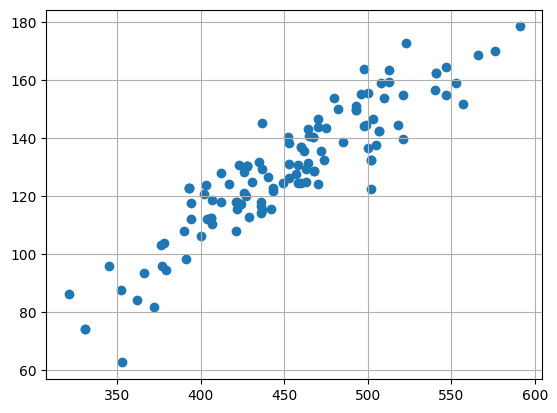

In [166]:
plt.grid()
plt.scatter(X.series, Y.series)

#### Задание 2. Для заданной выборки построить уравнения средней квадратичной регрессии $ x $ на $ y $ и $ y $ на $ x $ соответственно. Построить полученные прямые на множестве выборки. Объяснить результаты

(np.float64(452.2583333333333), np.float64(129.40416666666667))

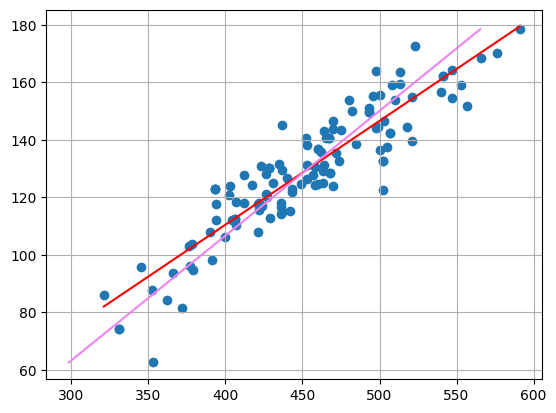

In [177]:
from scipy.optimize import leastsq
def build_model(X, Y, model, param_cnt, x0=None):
    if x0 is None:
        x0 = [0]*param_cnt
    params, _ = leastsq(lambda p: model(p, X.series) - Y.series, x0)
    return params
linear_model = lambda p, X: p[0]*X + p[1]
a,b = build_model(X, Y, linear_model, 2)
c,d = build_model(Y, X, linear_model, 2)
Xsort = np.array(sorted(X.series))
Ysort = np.array(sorted(Y.series))
plt.grid()
plt.scatter(X.series, Y.series)
plt.plot(Xsort, a*Xsort + b, 'r')
plt.plot(c*Ysort + d, Ysort, 'violet')
X.mean, Y.mean

Полученные прямые оптимальным в смысле МНК образом проходят через значения выборки. Данные прямые пересекаются в точке с координатами средних значений выборок.

#### Задание 3. Составить корреляционную таблицу для нахождения выборочного корреляционного отношения. Убедиться, что неравенства $ \eta_{xy} \geqslant |r_{xy}| $ и $ \eta_{yx} \geqslant |r_{xy}| $ выполняются

In [168]:
table = [[0]*X.k for _ in range(Y.k)]
for i in range(len(X.u_series)):
    table[Y.u_series[i]+Y.k//2][X.u_series[i]+X.k//2] += 1
table = np.array(table)

x_y_i = np.array( [np.average(X.bins, weights=table[i]) for i in range(X.k)] )
n_x = [sum(table[i]) for i in range(X.k)]

y_x_j = [np.average(Y.bins, weights=table[:, i]) for i in range(Y.k)]
n_y = [sum([row[i] for row in table]) for i in range(Y.k)]
# Код для вывода таблицы
def rnd(a, d=4):
    return 0 if a < 10**-d else round(a, d)
def rndlist(l, d=4):
    return [rnd(a, d) for a in l]
'''
print('| Y \\ X', *rndlist(X.bins), '$ n_{y_i} $', r'$ \bar{x_{y_i}} $', '', sep=' | ')
print("|----"*(X.k+3)+"|")
for i in range(X.k):
    print('', rnd(Y.bins[i]), *table[i],  n_x[i], rnd(x_y_i[i]), '', sep=' | ')

print('| $ n_{y_j} $', *n_y, sum([sum(row) for row in table]), '- | ', sep=' | ')
print(r'| $ \bar{y_{x_j}} $', *rndlist(y_x_j), '- | - | ', sep=' | ')
''';

| Y \ X | 340.2857 | 378.8571 | 417.4286 | 456.0 | 494.5714 | 533.1429 | 571.7143 | $ n_{y_i} $ | $ \bar{x_{y_i}} $ | 
|----|----|----|----|----|----|----|----|----|----|
 | 70.8786 | 3 | 0 | 0 | 0 | 0 | 0 | 0 | 3 | 340.2857 | 
 | 87.4357 | 2 | 4 | 0 | 0 | 0 | 0 | 0 | 6 | 366.0 | 
 | 103.9929 | 1 | 6 | 4 | 0 | 0 | 0 | 0 | 11 | 389.3766 | 
 | 120.55 | 0 | 4 | 20 | 14 | 1 | 0 | 0 | 39 | 429.2967 | 
 | 137.1071 | 0 | 0 | 5 | 19 | 9 | 2 | 0 | 35 | 464.8163 | 
 | 153.6643 | 0 | 0 | 0 | 1 | 11 | 3 | 2 | 17 | 508.1849 | 
 | 170.2214 | 0 | 0 | 0 | 0 | 2 | 4 | 3 | 9 | 537.4286 | 
| $ n_{y_j} $ | 6 | 14 | 29 | 34 | 23 | 9 | 5 | 120 | - | 
| $ \bar{y_{x_j}} $ | 81.9167 | 103.9929 | 121.1209 | 130.7765 | 147.1854 | 157.3437 | 163.5986 | - | - | 

In [169]:
# For X 
D_between_groups = np.sum(n_x * (x_y_i - X.u_mean) ** 2) / len(X.series)
D_common = np.mean((X.h*X.u_series+X.C - X.u_mean) ** 2)
eta_xy = (D_between_groups / D_common)**.5
print(eta_xy, r_xy)

0.8689851485966412 0.8653704587990387


In [170]:
# For Y 
D_between_groups = np.sum(n_y * (y_x_j - Y.u_mean) ** 2) / len(Y.series)
D_common = np.mean((Y.h*Y.u_series+Y.C - Y.u_mean) ** 2)
eta_yx = (D_between_groups / D_common)**.5
print(eta_yx, r_xy)

0.8779461447857082 0.8653704587990387


Неравенства $ \eta_{xy} \geqslant |r_{xy}| $ и $ \eta_{yx} \geqslant |r_{xy}| $ выполняются

#### Задание 4. Для заданной выборки построить корреляционную кривую параболического вида $ y = \beta_0 + \beta_1x + \beta_2x^2 $, сделать выводы.

-0.0005544404577872967 0.8630683363966438 -145.81721148440155


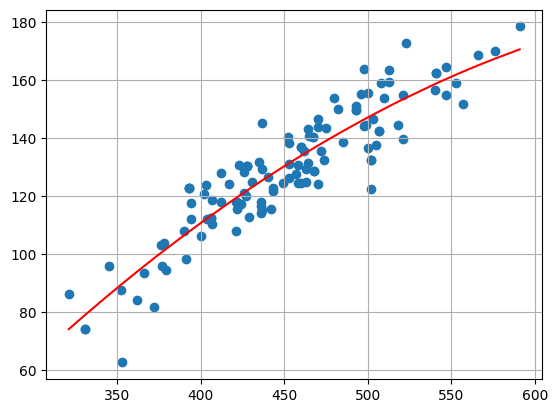

In [181]:
quadratic_model = lambda p, X: p[0]*X**2 + p[1]*X + p[2]
p = build_model(X, Y, quadratic_model, 3)
print(*p)
plt.grid()
plt.scatter(X.series, Y.series)
plt.plot(Xsort, quadratic_model(p, Xsort), 'r')

Коэффициент перед второй степенью на несколько порядков меньше остальных коэффициентов, что может говорить о слабой выраженности квадратичной зависимости. Это можно подтвердить и визуально: на участке аппроксимации парабола ведет себя практически линейно.

#### Задание 5. Для заданной выборки построить корреляционную кривую в зависимости от номера варианта и сделать выводы: 
     
- логарифмическая функция: $ y = \beta_0 + \beta_1\ln x $

-857.4160019020487 161.5990465219846


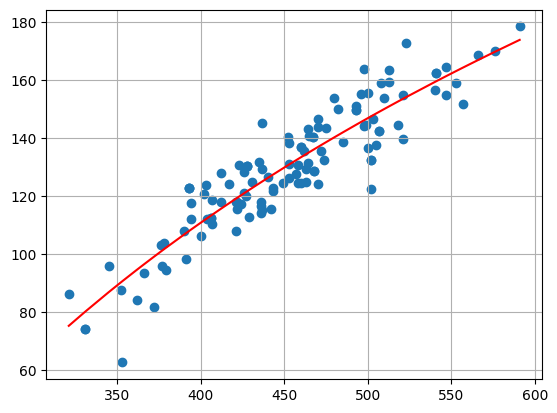

In [182]:
logarithmic_model = lambda p, X: p[0] + p[1] * np.log(X)
p = build_model(X, Y, logarithmic_model, 2)
print(*p)
plt.grid()
plt.scatter(X.series, Y.series)
plt.plot(Xsort, logarithmic_model(p, Xsort), 'r')

Полученная кривая также визуально не показывает результатов лучших, чем у прямой. Это вызвано в том числе тем, что данных недостаточно, чтобы отделить линейную зависимость от какой-либо другой.

## Выводы

В ходе работы были построены уравнения линейной регрессии $x$ на $y$ и $y$ на $x$, а также рассчитано корреляционное отношение $\eta_{xy}$. Оказалось, что линейная модель описывает данные с той же точностью, что и нелинейные модели. Это свидетельствует о том, что связь между переменными близка к линейной. Метод наименьших квадратов успешно применен для анализа данных.